# Analysis: Identified Fraud Accounts

#### Goal:
Define fraud/bad actors in FreshBooks platform.


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multipolyfit as mpf
import seaborn as sns
plt.style.use('ggplot')
from scipy import stats
get_ipython().magic(u'config IPCompleter.greedy=True')

sns.set(color_codes=True) 

## Fraud Accounts Lifespan

In [2]:
## Import fraud account life span (days to ban) data
df_fraud_accounts_lifespan =\
        pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_lifespan.tsv", sep="\t")


## Droping 'NaN' by zero 
df_fraud_accounts_lifespan = df_fraud_accounts_lifespan.fillna(0)

In [3]:
df_fraud_accounts_lifespan.tail(5)

,systemid,days_before_ban
357,1758644,690
358,1826920,742
359,2732755,631
360,732140,1542
361,1271218,1124


### Lifespan distribution of the fraud accounts

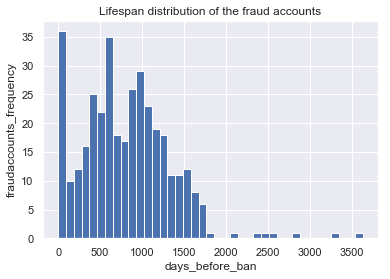

<Figure size 432x288 with 0 Axes>

In [4]:
## Histogram to represent the account_frequency vs. days_before_ban
plt.hist(df_fraud_accounts_lifespan['days_before_ban'], bins=39)
plt.xlabel('days_before_ban')
plt.ylabel('fraudaccounts_frequency')
plt.title('Lifespan distribution of the fraud accounts')
plt.show()

## Save figure
path = "/Users/dwahid/Documents/GitHub/fraud_detection/data/figures/"
fig_name = path + 'fig_fraud_accounts_lifespan.png'
plt.savefig(fig_name)

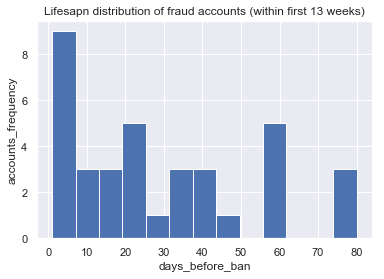

In [5]:
## Histogram to represent the account_frequency vs. days_before_ban (closer look)
n_bins = 13
outliers_cutoff = 91

histo_fraud_accounts_lifespan= sorted(df_fraud_accounts_lifespan['days_before_ban'])
histo_fraud_accounts_lifespan_leOutlier = [i for i in histo_fraud_accounts_lifespan if i < outliers_cutoff]
histo_fraud_accounts_lifespan_geOutlier = [i for i in histo_fraud_accounts_lifespan if i > outliers_cutoff]
histo_fraud_accounts_lifespan = [histo_fraud_accounts_lifespan_leOutlier, histo_fraud_accounts_lifespan_geOutlier ] 

plt.hist(histo_fraud_accounts_lifespan_leOutlier, n_bins, density=False, histtype='bar')
plt.xlabel('days_before_ban')
plt.ylabel('accounts_frequency')
# plt.xticks(ind, ('0', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13'))
plt.title('Lifesapn distribution of fraud accounts (within first 13 weeks)')

## Save Figure
path = "/Users/dwahid/Documents/GitHub/fraud_detection/data/figures/"
fig_name = path + 'fig_fraud_accounts_lifespan_le100days.png'
plt.savefig(fig_name)

### Data Import: Identified Fraud and Non-Fraud Accounts Features

In [321]:
## Importing Identifed Fraud Accounts
df_fraud_accounts_activity_day_07 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_07.tsv", sep="\t")
df_fraud_accounts_activity_day_14 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_14.tsv", sep="\t")
df_fraud_accounts_activity_day_21 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_21.tsv", sep="\t")
df_fraud_accounts_activity_day_28 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_28.tsv", sep="\t")
df_fraud_accounts_activity_day_35 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_35.tsv", sep="\t")
df_fraud_accounts_activity_day_42 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_42.tsv", sep="\t")
df_fraud_accounts_activity_day_49 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_49.tsv", sep="\t")
df_fraud_accounts_activity_day_56 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_56.tsv", sep="\t")
df_fraud_accounts_activity_day_63 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_63.tsv", sep="\t")
df_fraud_accounts_activity_day_70 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_70.tsv", sep="\t")
df_fraud_accounts_activity_day_77 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_77.tsv", sep="\t")
df_fraud_accounts_activity_day_84 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_84.tsv", sep="\t")
df_fraud_accounts_activity_day_91 = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/fraud_accounts_features_day_91.tsv", sep="\t")


In [322]:
## Importing Identified Non-Fraud Accounts
df_non_fraud_accounts_activity_day_07 =\
    pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/non_fraud_accounts_features_day_07_20180801_20190730.tsv", sep="\t")

In [323]:
df_non_fraud_accounts_activity_day_07.shape

(297, 93)

In [372]:
## Importing Identified All Accounts
df_all_accounts_day_07 =\
    pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/final_features_day_07_no_fbtest_onlyimp.tsv", sep="\t")

In [374]:
df_all_accounts_day_07.shape

(452528, 105)

### Indentifying Features Importance with Scores

In [324]:
## Creating a merge (Non Fraud and Fraud accounts) data set
df_fraud_data_07 = df_fraud_accounts_activity_day_07.copy()
df_fraud_data_07['fraud_label'] = '1'        # adding fraud_label = 1 in the fraud accounts

df_non_fraud_data_07 = df_non_fraud_accounts_activity_day_07.copy()
df_non_fraud_data_07['fraud_label'] = '0'    # adding fraud_label = 0 in the non-fraud accounts

df_data_07 = df_fraud_data_07.append(df_non_fraud_data_07)  # Joining fraud and non-fraud data sets
df_data_07 = df_data_07.reset_index(drop=True)

In [325]:
# list(df_data_07)

In [326]:
# Renaming columns names
df_data_07.rename(columns={ 'avg_wc_address_day_7': 'avg_wc_address', 
                    'avg_wc_description_day_7': 'avg_wc_description',
                    'avg_wc_notes_day_7': 'avg_wc_notes',
                    'avg_wc_terms_day_7': 'avg_wc_terms',
                    'client_count_day_7': 'client_count',
                    'invoice_count_day_7': 'invoice_count'}, inplace=True)

In [327]:
df_data_07.tail()

,activateexpense,activateotherincome,activatepayment,admin_email,admindeactivation,adminonlinepaymentattempt,adminpayinvoiceonlineinvoice,adminpayinvoiceonlinelistview,archiveclient,archiveexpense,...,updateclient,updatecompanyprofile,updatecontractor,updatecreditnote,updateestimate,updateexpense,updateinvoicesample,updateitem,updateservice,fraud_label
626,0.0,0,0.0,billing@webwisconsin.com,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0,0
627,0.0,0,0.0,ema.spus@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,6,0
628,0.0,0,0.0,proflame@shaw.ca,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,0.0,0.0,0.0,28.0,0.0,1.0,0.0,0,0
629,0.0,0,0.0,rruckman@nabcblues.org,0.0,0.0,0.0,0.0,0.0,0.0,...,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
630,0.0,0,0.0,stuart@sbmedia.co,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [328]:
# Create a copy of the datafram for analysis
df_data_07_v2 = df_data_07.copy()
df = df_data_07.copy()

In [329]:
df_data_07_v2.head()

,activateexpense,activateotherincome,activatepayment,admin_email,admindeactivation,adminonlinepaymentattempt,adminpayinvoiceonlineinvoice,adminpayinvoiceonlinelistview,archiveclient,archiveexpense,...,updateclient,updatecompanyprofile,updatecontractor,updatecreditnote,updateestimate,updateexpense,updateinvoicesample,updateitem,updateservice,fraud_label
0,0.0,0,0.0,sales@technicalsupporting.com,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,0.0,0,0.0,justin@freshlemonsolutions.com,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,0.0,0,0.0,arossrcr@roughcountryrusticfurniture.com,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,0.0,0,0.0,nazia.quraishi@technicianforyou.com,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,0.0,0,0.0,americanguy009@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [330]:
## Drop Identifying columns
columns = ['admin_email', 'is_freshbooks_account_active', 
           'is_paying', 'effective_date', 'is_sales_managed', 
           'signup_date', 'systemid', 'days_on_platform']
df_data_07_v2.drop(columns, inplace=True, axis=1)

In [331]:
df_data_07_v2.head()

,activateexpense,activateotherincome,activatepayment,admindeactivation,adminonlinepaymentattempt,adminpayinvoiceonlineinvoice,adminpayinvoiceonlinelistview,archiveclient,archiveexpense,archiveotherincome,...,updateclient,updatecompanyprofile,updatecontractor,updatecreditnote,updateestimate,updateexpense,updateinvoicesample,updateitem,updateservice,fraud_label
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1


In [332]:
## Spliting data (X) and target (y) 
target = ['fraud_label']
y = df_data_07_v2['fraud_label']

df_data_07_v2.drop(target, inplace=True, axis=1)
X = df_data_07_v2

In [333]:
X.head()

,activateexpense,activateotherincome,activatepayment,admindeactivation,adminonlinepaymentattempt,adminpayinvoiceonlineinvoice,adminpayinvoiceonlinelistview,archiveclient,archiveexpense,archiveotherincome,...,updatecategory,updateclient,updatecompanyprofile,updatecontractor,updatecreditnote,updateestimate,updateexpense,updateinvoicesample,updateitem,updateservice
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [334]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [335]:
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s, Score: %f" % (f+1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. surveyquestionanswered, Score: 0.156519
2. identitycompletedonboarding, Score: 0.133903
3. updatebusiness, Score: 0.123808
4. createservice, Score: 0.081417
5. updateinvoicesample, Score: 0.060200
6. emailinvoicesample, Score: 0.050092
7. createitem, Score: 0.020519
8. successfulonlinepayment, Score: 0.017868
9. fbpayfirstinvoicesent, Score: 0.017195
10. createbankaccount, Score: 0.016800
11. emailinvoice, Score: 0.015958
12. avg_wc_description, Score: 0.015774
13. createexpense, Score: 0.015403
14. updateclient, Score: 0.014678
15. invoice_count, Score: 0.014004
16. client_count, Score: 0.013899
17. updateservice, Score: 0.013565
18. avg_wc_terms, Score: 0.013499
19. createestimate, Score: 0.011827
20. avg_wc_notes, Score: 0.011478
21. enablepaymentgateway, Score: 0.011269
22. updateitem, Score: 0.010766
23. fbpayenabled, Score: 0.009944
24. createbanktransaction, Score: 0.009393
25. declinedonlinepaymentnotification, Score: 0.009280
26. updateestimate, Score: 0.00

### Features Distributions Similarity Measures


In [336]:
######### Day 07 GMM Clusters Distribution Distances #######################################

In [337]:
## Day 07: Fraud accounts activity day
columns1 = ['admin_email', 'days_on_platform', 'effective_date', 'is_sales_managed', 'signup_date', 'systemid']
df_fraud_accounts_activity_day_07.drop(columns1, inplace=True, axis=1)

In [338]:
df_fra_day_07_avg = pd.DataFrame(df_fraud_accounts_activity_day_07.mean())

In [339]:
## Import GMM (Day 07) clustering outputs
df_gmm_day_07 =\
    pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/analyzing_fraud_accounts/gmm_clustering_outputs_day_07_k7.tsv", sep="\t")

In [340]:
## Separating 'systemid' according to 'cluster_id'
df_c0 = df_gmm_day_07[df_gmm_day_07.cluster_id == 0]
df_c1 = df_gmm_day_07[df_gmm_day_07.cluster_id == 1]
df_c2 = df_gmm_day_07[df_gmm_day_07.cluster_id == 2]
df_c3 = df_gmm_day_07[df_gmm_day_07.cluster_id == 3]
df_c4 = df_gmm_day_07[df_gmm_day_07.cluster_id == 4]
df_c5 = df_gmm_day_07[df_gmm_day_07.cluster_id == 5]
df_c6 = df_gmm_day_07[df_gmm_day_07.cluster_id == 6]

In [341]:
## Droping non-numeric features
columns2 = ['systemid', 'cluster_id']
df_c0.drop(columns2, inplace=True, axis=1)
df_c1.drop(columns2, inplace=True, axis=1)
df_c2.drop(columns2, inplace=True, axis=1)
df_c3.drop(columns2, inplace=True, axis=1)
df_c4.drop(columns2, inplace=True, axis=1)
df_c5.drop(columns2, inplace=True, axis=1)
df_c6.drop(columns2, inplace=True, axis=1)

In [342]:
## Calculating 
df_c0_day_07_avg = pd.DataFrame(df_c0.mean())
df_c1_day_07_avg = pd.DataFrame(df_c1.mean())
df_c2_day_07_avg = pd.DataFrame(df_c2.mean())
df_c3_day_07_avg = pd.DataFrame(df_c3.mean())
df_c4_day_07_avg = pd.DataFrame(df_c4.mean())
df_c5_day_07_avg = pd.DataFrame(df_c5.mean())
df_c6_day_07_avg = pd.DataFrame(df_c6.mean())

In [343]:
## Calculating distance between two distribution
from scipy.spatial import distance
d0 = distance.minkowski(df_fra_day_07_avg, df_c0_day_07_avg)
d1 = distance.minkowski(df_fra_day_07_avg, df_c1_day_07_avg)
d2 = distance.minkowski(df_fra_day_07_avg, df_c2_day_07_avg)
d3 = distance.minkowski(df_fra_day_07_avg, df_c3_day_07_avg)
d4 = distance.minkowski(df_fra_day_07_avg, df_c4_day_07_avg)
d5 = distance.minkowski(df_fra_day_07_avg, df_c5_day_07_avg)
d6 = distance.minkowski(df_fra_day_07_avg, df_c6_day_07_avg)

In [344]:
# Store and print cluster sizes 
cls_dist  = {'cluster_id': ['cluster 00', 
                            'cluster 01', 
                            'cluster 02', 
                            'cluster 03', 
                            'cluster 04', 
                            'cluster 05', 
                            'cluster 06'], 
             'W01' : [d0, d1, d2, d3, d4, d5, d6]}
df_cls_dist = pd.DataFrame(cls_dist, columns =['cluster_id', 'W01'])
df_cls_dist

,cluster_id,W01
0,cluster 00,90.853991
1,cluster 01,144.671779
2,cluster 02,90.244348
3,cluster 03,177.049458
4,cluster 04,84.680784
5,cluster 05,183.078144
6,cluster 06,83.970370


### Fraud Account: Mutual Features' Dependency Plot:- 'invoice_count' vs. 'client_count'

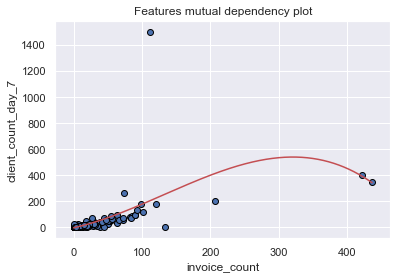

In [345]:
## 'declinedonlinepaymentnotification' vs. 'surveyquestionanswered'
feature_x = 'invoice_count_day_7'
feature_y = 'client_count_day_7'

## Features data
x1 = df_fraud_accounts_activity_day_07[feature_x]
y1 = df_fraud_accounts_activity_day_07[feature_y]

# Train Algorithm (Polynomial)
degree = 3
poly_fit = np.poly1d(np.polyfit(x1, y1, degree))

# Polynomial fit plot data
xx = np.linspace(min(x1), max(x1), 10000)
plt.plot(xx, poly_fit(xx), c='r',linestyle='-')

## Features mutual scatter plots
plt.scatter(x1, y1, edgecolors=(0, 0, 0))
plt.title('Features mutual dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

In [346]:
## Identify the outliers index
# for i in range(0,333):
#     print(i, x1[i], y1[i])

In [347]:
x2 = []
y2 = []

for i in range(0, 332):
    if i == 19:
        continue
    elif i == 207:
        continue
    elif i == 243:
        continue
    else:
        x2.append(x1[i])
        y2.append(y1[i])
            

In [348]:
## Check the removing of the outliers
# for i in range(0,len(x2)-1):
#     print(i, x2[i], y2[i])

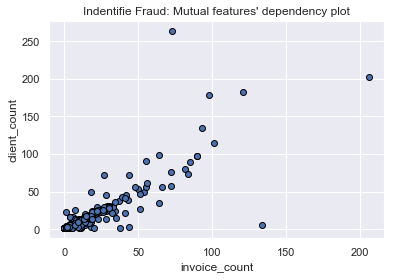

In [349]:
# Train Algorithm (Polynomial)
degree = 2
poly_fit = np.poly1d(np.polyfit(x2, y2, degree))

# Polynomial fit plot data
xx = np.linspace(min(x2), max(x2), 10000)
# plt.plot(xx, poly_fit(xx), c='r',linestyle='-')

## Features mutual scatter plots
plt.scatter(x2, y2, edgecolors=(0, 0, 0))
plt.title('Indentifie Fraud: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel('client_count')

plt.show()

### Fraud Account: Mutual Features' Dependency Plot: 'invoice_count' vs. 'emailinvoice'

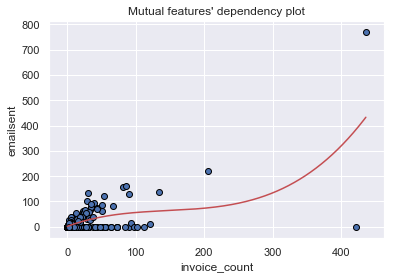

In [350]:
## 'declinedonlinepaymentnotification' vs. 'emailsent'
feature_x = 'invoice_count_day_7'
feature_y = 'emailsent'

## Features data
x1 = df_fraud_accounts_activity_day_07[feature_x]
y1 = df_fraud_accounts_activity_day_07[feature_y]

# Train Algorithm (Polynomial)
degree = 3
poly_fit = np.poly1d(np.polyfit(x1, y1, degree))

# Polynomial fit plot data
xx = np.linspace(min(x1), max(x1), 10000)
plt.plot(xx, poly_fit(xx), c='r',linestyle='-')

## Features mutual scatter plots
plt.scatter(x1, y1, edgecolors=(0, 0, 0))
plt.title('Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

In [351]:
## Identify the outliers index
# for i in range(0,333):
#     print(i, x1[i], y1[i])

In [352]:
## Removing the outliers
x2 = []
y2 = []

out = [2, 7, 19, 26, 51, 56, 57, 89, 185, 193, 
       203, 207, 212, 225, 228, 237, 242, 243, 247, 
       248, 258, 262, 275, 310]
for i in range(0, 332):
    if i in out:
        continue
    else:
        x2.append(x1[i])
        y2.append(y1[i])


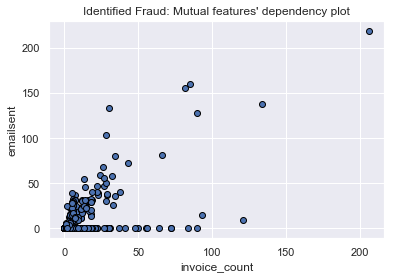

In [353]:
## Plot after removing outliers
# Train Algorithm (Polynomial)
degree = 2
poly_fit = np.poly1d(np.polyfit(x2, y2, degree))

# Polynomial fit plot data
xx = np.linspace(min(x2), max(x2), 10000)
# plt.plot(xx, poly_fit(xx), c='r',linestyle='-')

## Features mutual scatter plots
plt.scatter(x2, y2, edgecolors=(0, 0, 0))
plt.title('Identified Fraud: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

### Non Fraud Account: Mutual Features' Dependency Plot - 'invoice_count' vs. 'emailsent'

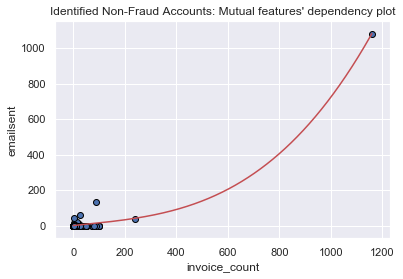

In [361]:
## 'declinedonlinepaymentnotification' vs. 'emailsent'
feature_x = 'invoice_count_day_7'
feature_y = 'emailsent'

## Features data
x1 = df_non_fraud_accounts_activity_day_07[feature_x]
y1 = df_non_fraud_accounts_activity_day_07[feature_y]

# Train Algorithm (Polynomial)
degree = 3
poly_fit = np.poly1d(np.polyfit(x1, y1, degree))

# Polynomial fit plot data
xx = np.linspace(min(x1), max(x1), 10000)
plt.plot(xx, poly_fit(xx), c='r',linestyle='-')

## Features mutual scatter plots
plt.scatter(x1, y1, edgecolors=(0, 0, 0))
plt.title('Identified Non-Fraud Accounts: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

In [355]:
## Identify the outliers index
# for i in range(0,len(x1)-1):
#     print(i, x1[i], y1[i])

In [362]:
## Removing the outliers
x2 = []
y2 = []

out = [127, 173,2, 173, 201, 228, 267]
for i in range(0, len(x1)):
    if i in out:
        continue
    else:
        x2.append(x1[i])
        y2.append(y1[i])


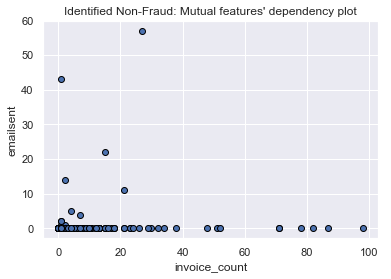

In [363]:
## Plot after removing outliers
# Train Algorithm (Polynomial)
degree = 2
poly_fit = np.poly1d(np.polyfit(x2, y2, degree))

# Polynomial fit plot data
xx = np.linspace(min(x2), max(x2), 10000)
# plt.plot(xx, poly_fit(xx), c='r',linestyle='-')

## Features mutual scatter plots
plt.scatter(x2, y2, edgecolors=(0, 0, 0))
plt.title('Identified Non-Fraud: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

### Non Fraud Account: Mutual Dependency Plot - 'invoice_count' vs. 'client_count'

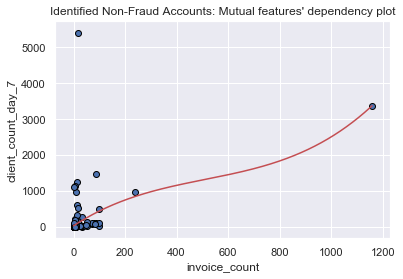

In [364]:
## 'declinedonlinepaymentnotification' vs. 'emailsent'
feature_x = 'invoice_count_day_7'
feature_y = 'client_count_day_7'

## Features data
x1 = df_non_fraud_accounts_activity_day_07[feature_x]
y1 = df_non_fraud_accounts_activity_day_07[feature_y]

# Train Algorithm (Polynomial)
degree = 3
poly_fit = np.poly1d(np.polyfit(x1, y1, degree))

# Polynomial fit plot data
xx = np.linspace(min(x1), max(x1), 10000)
plt.plot(xx, poly_fit(xx), c='r',linestyle='-')

## Features mutual scatter plots
plt.scatter(x1, y1, edgecolors=(0, 0, 0))
plt.title('Identified Non-Fraud Accounts: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

In [371]:
## Identify the outliers index
# for i in range(0,len(x1)-1):
#     print(i, x1[i], y1[i])

In [369]:
## Removing the outliers
x2 = []
y2 = []

out = [21, 32, 91, 149, 155, 170, 184, 201, 228, 234, 264, 267, 285]
for i in range(0, len(x1)):
    if i in out:
        continue
    else:
        x2.append(x1[i])
        y2.append(y1[i])


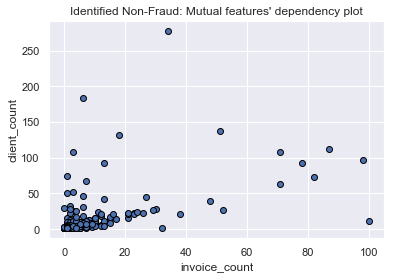

In [370]:
## Plot after removing outliers
# Train Algorithm (Polynomial)
degree = 2
poly_fit = np.poly1d(np.polyfit(x2, y2, degree))

# Polynomial fit plot data
xx = np.linspace(min(x2), max(x2), 10000)
# plt.plot(xx, poly_fit(xx), c='r',linestyle='-')

## Features mutual scatter plots
plt.scatter(x2, y2, edgecolors=(0, 0, 0))
plt.title('Identified Non-Fraud: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel('client_count')

plt.show()

### All Accounts: Mutual Features' Dependency Plot

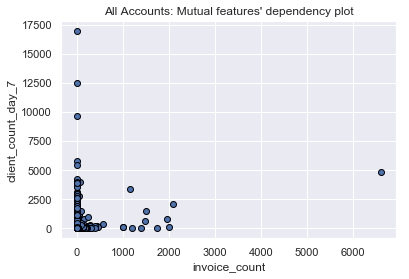

In [375]:
## 'declinedonlinepaymentnotification' vs. 'emailsent'
feature_x = 'invoice_count_day_7'
feature_y = 'client_count_day_7'

## Features data
x3 = df_all_accounts_day_07[feature_x]
y3 = df_all_accounts_day_07[feature_y]

## Features mutual scatter plots
plt.scatter(x3, y3, edgecolors=(0, 0, 0))
plt.title('All Accounts: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

In [377]:
## Removing outliers
x4 = []
y4 = []

x_cut = 1000
y_cut = 5000

for i in range(0, len(x3)-1):
    if x3[i] < x_cut and y3[i] < y_cut :
        x4.append(x3[i])
        y4.append(y3[i])
    else:
        continue

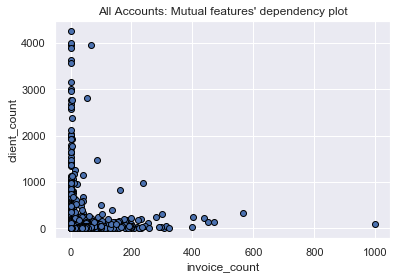

In [378]:

## Features mutual scatter plots
plt.scatter(x4, y4, edgecolors=(0, 0, 0))
plt.title('All Accounts: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel('client_count')

plt.show()

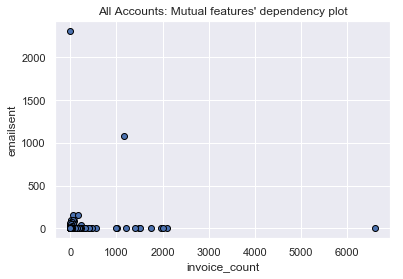

In [379]:
## 'declinedonlinepaymentnotification' vs. 'emailsent'
feature_x = 'invoice_count_day_7'
feature_y = 'emailsent'

## Features data
x3 = df_all_accounts_day_07[feature_x]
y3 = df_all_accounts_day_07[feature_y]

## Features mutual scatter plots
plt.scatter(x3, y3, edgecolors=(0, 0, 0))
plt.title('All Accounts: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

In [380]:
## Removing outliers
x4 = []
y4 = []

x_cut = 1000
y_cut = 500

for i in range(0, len(x3)-1):
    if x3[i] < x_cut and y3[i] < y_cut :
        x4.append(x3[i])
        y4.append(y3[i])
    else:
        continue

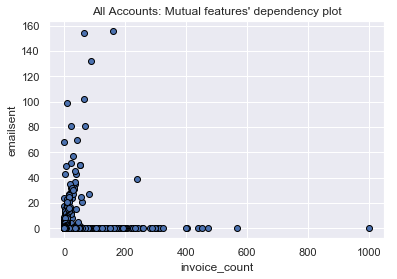

In [381]:

## Features mutual scatter plots
plt.scatter(x4, y4, edgecolors=(0, 0, 0))
plt.title('All Accounts: Mutual features\' dependency plot')
plt.xlabel('invoice_count')
plt.ylabel(feature_y)

plt.show()

### Client distribution of the fraud accounts

In [ ]:
# Histogram for client number distribution with outliers cutoff 
n_bins = 10
outliers_cutoff = 1000

histo_client_fraud_account = sorted(df_fraud_accounts_activity_v2['client_count'])
histo_client_fraud_account_leOutlier = [i for i in histo_client_fraud_account if i < outliers_cutoff]
histo_client_fraud_account_geOutlier = [i for i in histo_client_fraud_account if i > outliers_cutoff]
histo_client_fraud_account = [histo_client_fraud_account_leOutlier, histo_client_fraud_account_geOutlier ] 


fig, axes = plt.subplots(ncols=2, figsize=(15,5))
ax0, ax1 = axes.flatten()

ax0.hist(histo_client_fraud_account_leOutlier, n_bins, density=False, histtype='bar')
ax0.set_xlabel('client_count')
ax0.set_ylabel('accounts_frequency')
ax0.set_title('Client distribution of the fraud accounts (less than ' + str(outliers_cutoff) + ')')

ax1.hist(histo_client_fraud_account_geOutlier, n_bins, density=False, histtype='bar')   
ax1.set_xlabel('client_count')
ax1.set_ylabel('accounts_frequency')
ax1.set_title('Client distribution of the fraud accounts (greater than ' + str(outliers_cutoff) + ')')

### Client count over different time periods

In [ ]:
df = df_fraud_accounts_activity_v2[['client_count_day_7',
                                 'client_count_day_15',
                                 'client_count_day_30',
                                 'client_count_day_45',
                                 'client_count_day_60',
                                 'client_count_day_75',
                                 'client_count_day_90',
                                 'client_count_month_6',
                                 'client_count_year_1',
                                 'client_count_year_2',
                                 'client_count_year_3',
                                 'client_count_year_4',
                                 'client_count_year_5',
                                 'client_count_year_6',
                                 'client_count_year_7',
                                 'client_count_year_8',
                                 'client_count_year_9',
                                 'client_count_year_10'
                                ]].dropna().astype(int)

In [ ]:
# Pair-to-pair cross-validation plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

#------------------------------------------------------
x0 = df['client_count_day_7']
y0 = df['client_count_day_15']

ax0.scatter(x0, y0, edgecolors=(0, 0, 0))
ax0.plot([y0.min(), y0.max()], [y0.min(), y0.max()], 'k--', lw=2)
ax0.set_xlabel('client_count_day_7')
ax0.set_ylabel('client_count_day_15')

#------------------------------------------------------
x1 = df['client_count_day_15']
y1 = df['client_count_day_30']

ax1.scatter(x1, y1, edgecolors=(0, 0, 0))
ax1.plot([y1.min(), y1.max()], [y1.min(), y1.max()], 'k--', lw=2)
ax1.set_xlabel('client_count_day_15')
ax1.set_ylabel('client_count_day_30')

#------------------------------------------------------
x2 = df['client_count_day_30']
y2 = df['client_count_day_45']

ax2.scatter(x2, y2, edgecolors=(0, 0, 0))
ax2.plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'k--', lw=2)
ax2.set_xlabel('client_count_day_30')
ax2.set_ylabel('client_count_day_45')


#------------------------------------------------------
x3 = df['client_count_day_45']
y3 = df['client_count_day_60']

ax3.scatter(x3, y3, edgecolors=(0, 0, 0))
ax3.plot([y3.min(), y3.max()], [y3.min(), y3.max()], 'k--', lw=2)
ax3.set_xlabel('client_count_day_45')
ax3.set_ylabel('client_count_day_60')

#------------------------------------------------------
x4 = df['client_count_day_60']
y4 = df['client_count_day_75']

ax4.scatter(x4, y4, edgecolors=(0, 0, 0))
ax4.plot([y4.min(), y4.max()], [y4.min(), y4.max()], 'k--', lw=2)
ax4.set_xlabel('client_count_day_60')
ax4.set_ylabel('client_count_day_75')


#------------------------------------------------------
x5 = df['client_count_day_75']
y5 = df['client_count_day_90']

ax5.scatter(x5, y5, edgecolors=(0, 0, 0))
ax5.plot([y5.min(), y5.max()], [y5.min(), y5.max()], 'k--', lw=2)
ax5.set_xlabel('client_count_day_75')
ax5.set_ylabel('client_count_day_90')

plt.show()

In [ ]:
# Aggregrating column values
col_count = {'client_count_day_7':[df['client_count_day_7'].sum()],
             'client_count_day_15':[df['client_count_day_15'].sum()],
             'client_count_day_30':[df['client_count_day_30'].sum()],
             'client_count_day_45':[df['client_count_day_45'].sum()],
             'client_count_day_60':[df['client_count_day_60'].sum()],
             'client_count_day_75':[df['client_count_day_75'].sum()],
             'client_count_day_90':[df['client_count_day_90'].sum()],
             'client_count_month_6':[df['client_count_month_6'].sum()],
             'client_count_year_1':[df['client_count_year_1'].sum()],
             'client_count_year_2':[df['client_count_year_2'].sum()],
             'client_count_year_3':[df['client_count_year_3'].sum()],
             'client_count_year_4':[df['client_count_year_4'].sum()],
             'client_count_year_5':[df['client_count_year_5'].sum()],
             'client_count_year_6':[df['client_count_year_6'].sum()],
             'client_count_year_7':[df['client_count_year_7'].sum()],
             'client_count_year_8':[df['client_count_year_8'].sum()],
             'client_count_year_9':[df['client_count_year_9'].sum()],
             'client_count_year_10':[df['client_count_year_10'].sum()]
            }

df2 = pd.DataFrame(col_count, columns=[ 'client_count_day_7', 'client_count_day_15', 'client_count_day_30',
                                        'client_count_day_45','client_count_day_60', 'client_count_day_75',
                                        'client_count_day_90','client_count_month_6','client_count_year_1',
                                        'client_count_year_2','client_count_year_3', 'client_count_year_4',
                                        'client_count_year_5','client_count_year_6', 'client_count_year_7',
                                        'client_count_year_8','client_count_year_9', 'client_count_year_10'
                                      ])


In [ ]:
df2

In [ ]:
height = [10473, 16808, 24865, 
          31068, 36064, 40556, 
          44526, 62225, 84201,
          105868, 109745, 111486,
          112152, 112520, 112866, 
          113054, 113172, 113192]
bars = ('day_7',  'day_15', 'day_30', 'day_45',  'day_60', 'day_75', 
        'day_90', 'month_6',  'year_1',  'year_2',   'year_3',  'year_4',
        'year_5',  'year_6',  'year_7',   'year_8',   'year_9',  'year_10'
        )
x_pos = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19]
y_pos = np.arange(len(bars))

# Create legend
plt.legend()

# Create bars
plt.bar(y_pos, height, width=0.9)


# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90)
 
# Show graphic
plt.xlabel('fraud_accounts_lifespan_period')
plt.ylabel('frequency')
plt.title('Client count in different time periods of fraud account lifespan')
plt.show() 

#### Client Count of Fraud Accounts: Column Statistics

In [ ]:
df_client_count_fraud_account_stat = df.describe()
df_client_count_fraud_account_stat

### Invoice Count Activities of Fraud Accounts

In [ ]:
# Histogram for invoice number distribution
n_bins = 10
plt.hist(df_fraud_accounts_activity_v2['invoice_count'], n_bins, density=False, histtype='bar')
plt.xlabel('invoice_count')
plt.ylabel('accounts_frequency')
plt.title('Invoicedistribution of the fraud accounts (less than ' + str(outliers_cutoff) + ')')

In [ ]:
# Histogram for invoice number distribution with outliers cutoff 
n_bins = 10
outliers_cutoff = 500

invoice_count_sorted_fraud_account = sorted(df_fraud_accounts_activity_v2['invoice_count'])
invoice_count_sorted_fraud_account_leOutlier = [i for i in invoice_count_sorted_fraud_account if i < outliers_cutoff]
invoice_count_sorted_fraud_account_geOutlier = [i for i in invoice_count_sorted_fraud_account if i > outliers_cutoff]
#histo_invoice_fraud_account = [histo_invoice_fraud_account_leOutlier, histo_invoice_fraud_account_geOutlier ] 


fig, axes = plt.subplots(ncols=2, figsize=(15,5))
ax0, ax1 = axes.flatten()

ax0.hist(invoice_count_sorted_fraud_account_leOutlier, n_bins, density=False, histtype='bar')
ax0.set_xlabel('invoice_count')
ax0.set_ylabel('accounts_frequency')
ax0.set_title('Invoicedistribution of the fraud accounts (less than ' + str(outliers_cutoff) + ')')

ax1.hist(invoice_count_sorted_fraud_account_geOutlier, n_bins, density=False, histtype='bar')   
ax1.set_xlabel('invoice_count')
ax1.set_ylabel('accounts_frequency')
ax1.set_title('Invoice distribution of the fraud accounts (greater than ' + str(outliers_cutoff) + ')')


### Client count over different time periods

In [ ]:
df3 = df_fraud_accounts_activity_v2[['invoice_count_day_7',
                                 'invoice_count_day_15',
                                 'invoice_count_day_30',
                                 'invoice_count_day_45',
                                 'invoice_count_day_60',
                                 'invoice_count_day_75',
                                 'invoice_count_day_90',
                                 'invoice_count_month_6',
                                 'invoice_count_year_1',
                                 'invoice_count_year_2',
                                 'invoice_count_year_3',
                                 'invoice_count_year_4',
                                 'invoice_count_year_5',
                                 'invoice_count_year_6',
                                 'invoice_count_year_7',
                                 'invoice_count_year_8',
                                 'invoice_count_year_9',
                                 'invoice_count_year_10'
                                ]].dropna().astype(int)

In [ ]:
# Pair-to-pair cross-validation plot for invoce count in different time period
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

#------------------------------------------------------
x0 = df3['invoice_count_day_7']
y0 = df3['invoice_count_day_15']

ax0.scatter(x0, y0, edgecolors=(0, 0, 0))
ax0.plot([y0.min(), y0.max()], [y0.min(), y0.max()], 'k--', lw=2)
ax0.set_xlabel('invoice_count_day_7')
ax0.set_ylabel('invoice_count_day_15')

#------------------------------------------------------
x1 = df3['invoice_count_day_15']
y1 = df3['invoice_count_day_30']

ax1.scatter(x1, y1, edgecolors=(0, 0, 0))
ax1.plot([y1.min(), y1.max()], [y1.min(), y1.max()], 'k--', lw=2)
ax1.set_xlabel('invoice_count_day_15')
ax1.set_ylabel('invoice_count_day_30')

#------------------------------------------------------
x2 = df3['invoice_count_day_30']
y2 = df3['invoice_count_day_45']

ax2.scatter(x2, y2, edgecolors=(0, 0, 0))
ax2.plot([y2.min(), y2.max()], [y2.min(), y2.max()], 'k--', lw=2)
ax2.set_xlabel('invoice_count_day_30')
ax2.set_ylabel('invoice_count_day_45')


#------------------------------------------------------
x3 = df3['invoice_count_day_45']
y3 = df3['invoice_count_day_60']

ax3.scatter(x3, y3, edgecolors=(0, 0, 0))
ax3.plot([y3.min(), y3.max()], [y3.min(), y3.max()], 'k--', lw=2)
ax3.set_xlabel('invoice_count_day_45')
ax3.set_ylabel('invoice_count_day_60')

#------------------------------------------------------
x4 = df3['invoice_count_day_60']
y4 = df3['invoice_count_day_75']

ax4.scatter(x4, y4, edgecolors=(0, 0, 0))
ax4.plot([y4.min(), y4.max()], [y4.min(), y4.max()], 'k--', lw=2)
ax4.set_xlabel('client_count_day_60')
ax4.set_ylabel('client_count_day_75')


#------------------------------------------------------
x5 = df3['invoice_count_day_75']
y5 = df3['invoice_count_day_90']

ax5.scatter(x5, y5, edgecolors=(0, 0, 0))
ax5.plot([y5.min(), y5.max()], [y5.min(), y5.max()], 'k--', lw=2)
ax5.set_xlabel('invoice_count_day_75')
ax5.set_ylabel('invoice_count_day_90')

plt.show()

In [ ]:
# Aggregrating column values
invoice_col_count = {'invoice_count_day_7' :[df3['invoice_count_day_7'].sum()],
                     'invoice_count_day_15':[df3['invoice_count_day_15'].sum()],
                     'invoice_count_day_30':[df3['invoice_count_day_30'].sum()],
                     'invoice_count_day_45':[df3['invoice_count_day_45'].sum()],
                     'invoice_count_day_60':[df3['invoice_count_day_60'].sum()],
                     'invoice_count_day_75':[df3['invoice_count_day_75'].sum()],
                     'invoice_count_day_90':[df3['invoice_count_day_90'].sum()],
                     'invoice_count_month_6':[df3['invoice_count_month_6'].sum()],
                     'invoice_count_year_1':[df3['invoice_count_year_1'].sum()],
                     'invoice_count_year_2':[df3['invoice_count_year_2'].sum()],
                     'invoice_count_year_3':[df3['invoice_count_year_3'].sum()],
                     'invoice_count_year_4':[df3['invoice_count_year_4'].sum()],
                     'invoice_count_year_5':[df3['invoice_count_year_5'].sum()],
                     'invoice_count_year_6':[df3['invoice_count_year_6'].sum()],
                     'invoice_count_year_7':[df3['invoice_count_year_7'].sum()],
                     'invoice_count_year_8':[df3['invoice_count_year_8'].sum()],
                     'invoice_count_year_9':[df3['invoice_count_year_9'].sum()],
                     'invoice_count_year_10':[df3['invoice_count_year_10'].sum()]
            }

df4 = pd.DataFrame(invoice_col_count, columns=[ 'invoice_count_day_7', 'invoice_count_day_15', 'invoice_count_day_30',
                                                'invoice_count_day_45','invoice_count_day_60', 'invoice_count_day_75',
                                                'invoice_count_day_90','invoice_count_month_6','invoice_count_year_1',
                                                'invoice_count_year_2','invoice_count_year_3', 'invoice_count_year_4',
                                                'invoice_count_year_5','invoice_count_year_6', 'invoice_count_year_7',
                                                'invoice_count_year_8','invoice_count_year_9', 'invoice_count_year_10'
                                              ])
# Printing histogram bar heitht
height = df4.values.tolist()
height

In [ ]:
height = [15769, 10574, 19640, 26998, 33646, 39673, 45588, 73193, 
          114960, 175531, 204357, 220022, 226549, 231151, 236013, 
          239781, 240574, 240804]

bars = ('day_7',  'day_15', 'day_30', 'day_45',  'day_60', 'day_75', 
        'day_90', 'month_6',  'year_1',  'year_2',   'year_3',  'year_4',
        'year_5',  'year_6',  'year_7',   'year_8',   'year_9',  'year_10'
        )
x_pos = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19]
y_pos = np.arange(len(bars))

# Create legend
plt.legend()

# Create bars
plt.bar(y_pos, height, width=0.9)


# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90)
 
# Show graphic
plt.xlabel('fraud_accounts_lifespan_period')
plt.ylabel('frequency')
plt.title('Client count in different time periods of fraud account lifespan')
plt.show()

In [ ]:
height = [15769, 10574, 19640, 
          26998, 33646, 39673, 
          45588, 73193, 114960]

bars = ('day_7',  'day_15', 'day_30', 
        'day_45',  'day_60', 'day_75', 
        'day_90', 'month_6',  'year_1'
        )
x_pos = [0,1,2,3,4,5,6,7,8]
y_pos = np.arange(len(bars))

# Create legend
plt.legend()

# Create bars
plt.bar(y_pos, height, width=0.9)


# Create names on the x-axis
plt.xticks(y_pos, bars, rotation=90)
 
# Show graphic
plt.xlabel('fraud_accounts_lifespan_period')
plt.ylabel('frequency')
plt.title('Client count in different time periods of fraud account lifespan')
plt.show()

### Word Count per Invoice in Fraud Accounts

#### Invoice description word count

In [ ]:
# Import fraud account life span (days to ban) data
df_fraud_accounts_invoices = pd.read_csv("/Users/dwahid/Documents/GitHub/fraud_detection/data/fraud_accounts_invoices_descriptions.csv", sep="\t")

In [ ]:
df_fraud_accounts_invoices.head(5)

In [ ]:
import re
def words_count (strg):
    
    #print(strg)
    
    if strg == '' or pd.isnull(strg):
        no_of_words = 0
        #print('NaN')
    else:
        strg_words_list = re.findall(r"[\w']+", strg)
        no_of_words = len(strg_words_list)

        
        #print(strg_words_list)
    
    return no_of_words 
    

In [ ]:
# Words count list
words_count_list_description = []  # for invoice description
words_count_list_notes = []        # for invoice notes
words_count_list_terms = []        # for invoice terms
words_count_list_address = []      # for invoice address

# Iterating through the row of the dataframe 
for index, row in df_fraud_accounts_invoices.iterrows():
    #print('\n')
    #print(index)
    
    # itemes string
    description = row['description']
    notes = row['notes']
    terms = row['terms']
    address = row['address']
    
    # word count using 'word_count(string)' function
    wc_description = words_count(description)
    wc_notes = words_count(notes)
    wc_terms = words_count(terms)
    wc_address = words_count(address)
    
    # adding word counts to the list
    words_count_list_description.append(wc_description)
    words_count_list_notes.append(wc_notes)
    words_count_list_terms.append(wc_terms)
    words_count_list_address.append(wc_address)
    
    #print(index, invoice_description, wc)
    #print(index, wc)
    #print('\n')


In [ ]:
# Adding words count columns in the dataframe
df_fraud_accounts_invoices['description_words_count'] = words_count_list_description
df_fraud_accounts_invoices['notes_words_count'] = words_count_list_notes
df_fraud_accounts_invoices['terms_words_count'] = words_count_list_terms
df_fraud_accounts_invoices['address_words_count'] = words_count_list_address


In [ ]:
df_fraud_accounts_invoices.head()